In [1]:
# We will need some functionality 
from typing import List 

import time

# and from math related libraries
import qutip as qt

import matplotlib.pyplot as plt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

from qiskit.utils.mitigation import CompleteMeasFitter


import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
#from qiskit.test.mock import FakeVigo
from qiskit.providers.fake_provider import FakeVigo

from qiskit.circuit import Parameter

In [13]:
def analog_ansatz(analog_block,num_qubits,repeats=1):
    psi = Parameter('a')
    theta = Parameter('b')

    qr = QuantumRegister(num_qubits)
    ansatz = QuantumCircuit(qr)

    
    for r in range(repeats):
        # add single-qubit rotation gates to all for variational parameter
        ansatz.rx(psi, range(num_qubits))
        
        # add single-qubit rotation gates to all for second variational parameter
        ansatz.rz(theta, range(num_qubits))

        # analog block for multi-qubit mixing
        ansatz.unitary(analog_block, [qr[i] for i in range(num_qubits)], label='analog block')

    ansatz.barrier()
    
    return ansatz

def digital_ansatz(num_qubits,repeats=1):
    psi = Parameter('a')
    theta = Parameter('b')
 
    ansatz = QuantumCircuit(num_qubits)
    for r in range(repeats):
        # add single-qubit rotation gates to all for variational parameter
        ansatz.rx(psi, range(num_qubits))
        
        # add single-qubit rotation gates to all for second variational parameter
        ansatz.rz(theta, range(num_qubits))

        # add chain of CNOTS for multi-qubit mixing
        for i in range(num_qubits-1):
            ansatz.cx(i, i+1)
        ansatz.cx(num_qubits-1,0)
    
    ansatz.barrier()
    
    return ansatz

In [23]:

device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model, 
                     measurement_error_mitigation_cls=CompleteMeasFitter, 
                     cals_matrix_refresh_period=30)

        
    

def get_eigenvalue(which,num_qubits,ham_op,repeats=1,analog_block=0.0):
    counts = []
    values = []
    if which == "digital":
        chosen_ansatz = digital_ansatz(num_qubits,repeats)#TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')#
    else:
        chosen_ansatz = analog_ansatz(analog_block,num_qubits,repeats)
    
    #print(chosen_ansatz)
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(chosen_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=ham_op)
    final_eigval = result.eigenvalue.real
    
    return counts,values,final_eigval
    
#     print(which,": ",final_eigval)
    
#     pylab.rcParams['figure.figsize'] = (12, 4)
#     pylab.plot(counts, values, label=which)
#     pylab.xlabel('Eval count')
#     pylab.ylabel('Energy')
#     pylab.legend()
#     pylab.title('Convergence with noise, measurement error mitigation enabled');
    
    

In [27]:
#H2_op = (-1.052373245772859 * I ^ I) + (0.39793742484318045 * I ^ Z) + (-0.39793742484318045 * Z ^ I) + (-0.01128010425623538 * Z ^ Z) + (0.18093119978423156 * X ^ X)
qubits_count = 3
block_iters = 1
coeff = 2.
H2_op = coeff * Z
for i in range(qubits_count-1):
    H2_op ^= Z

hamiltonian = H2_op.to_matrix()
ham_block = HamiltonianGate(data=hamiltonian, time=2) 

print(f'Number of qubits: {H2_op.num_qubits}')

#get_eigenvalue("analog",qubits_count,H2_op,block_iters,ham_block)
dats = get_eigenvalue("digital",qubits_count,H2_op,block_iters)


Number of qubits: 3


(70, [0.008235294117647193, 0.0, 0.008235294117647193, 0.0011764705882351604, 0.007058823529412033, 0.004705882352941177, 0.004705882352941177, 0.0023529411764705885, 0.001176470588235428, 0.0035294117647060165, 0.0035294117647060165, 0.0035294117647060165, 0.0035294117647060165, 0.0011764705882352942, 0.0011764705882352942, 0.0, 0.0035294117647060165, 0.0, 0.0035294117647060165, 0.001176470588235428, 0.001176470588235428, 0.0, 0.0035294117647060165, 0.0023529411764705885, 0.001176470588235428, 0.0, 0.0035294117647060165, 0.0035294117647060165, 0.0011764705882352942, 0.0047058823529413105, 0.0035294117647060165, 0.001176470588235428, 1.3374922084896005e-16, 0.0, 0.0023529411764707225, 0.0, 0.0023529411764707225, 0.0023529411764707225, 0.0047058823529413105, 0.0047058823529413105, 0.0047058823529413105, 0.0047058823529413105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


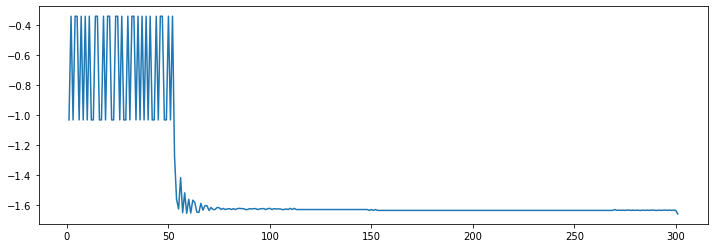

In [47]:
def get_conv_time(steps,vals,stable_time=50,error=0.01):
    changes = [ abs((vals[i] - vals[i+1])/vals[-1]) for i in range(stable_time)]
    for t in range(len(vals)-stable_time-2):
        if max(changes) <= error:
            return t,changes
        else:
            changes.append(abs((vals[t+stable_time] - vals[t+stable_time+1])/vals[-1]))
            del changes[0]
    
convdats = get_conv_time(dats[0],dats[1])
print(convdats)
plt.plot(dats[0],dats[1])
plt.show()